# Curve fitting

This notebook will perform a simple Bayesian curve fitting in `Python`. We will use NUTS sampler to sample from the posterior distribution. First, let's load necessary packages.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from jax.random import PRNGKey, split
import jax.numpy as jnp
import numpyro
from numpyro.infer import MCMC, NUTS
from numpyro import distributions as dist
import arviz as az
import corner

import jax
jax.config.update(
    "jax_enable_x64", True
)  # For 64-bit precision since JAX defaults to 32-bit

/Users/japa6985/opt/anaconda3/envs/exo/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Now, let's generate fake data. We will use the following function to generate the dataset:

$$ y = \exp{(-5x)} \cdot \sin{(20x)} + 0.5x + 2$$

Text(0, 0.5, 'y')

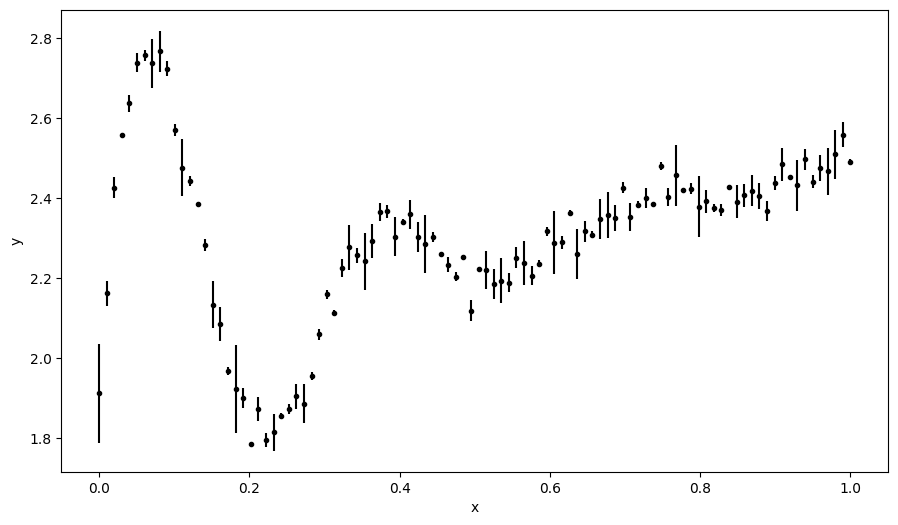

In [2]:
x = np.linspace(0., 1., 100)
y = np.exp(-5.0 * x) * np.sin(20.0 * x) + 0.5 * x + 2.0 + np.random.normal(0., 0.04, len(x))
yerr = np.abs( np.random.normal(0., 0.04, len(x)) )

fig, axs = plt.subplots(figsize=(16/1.5, 9/1.5))
axs.errorbar(x, y, yerr=yerr, color='k', fmt='.')
axs.set_xlabel('x')
axs.set_ylabel('y')

Now, we will define "likelihood" function. We will use the model function in the following form:

$$y = \exp{(ax)}\cdot\sin{(bx)} + cx + d$$

The $a$, $b$, $c$, and $d$ are the four obvious free variables. Additionally, we will also fit for the additional white noise (variable $\sigma$).

In [3]:
# And modelling it
## First defining a numpyro model
def model():
    # Priors on the model parameters
    a = numpyro.sample('a', dist.Uniform(low=-10., high=10.))
    b = numpyro.sample('b', dist.Uniform(low=0., high=50.))
    c = numpyro.sample('c', dist.Uniform(low=0., high=1.))
    d = numpyro.sample('d', dist.Uniform(low=0., high=10.))
    s2 = numpyro.sample('s2', dist.TwoSidedTruncatedDistribution(dist.Normal(loc=0, scale=100), low=0, high=1e6))
    
    # Let's also track the value of line for each iteration
    numpyro.deterministic('y', jnp.exp(a * x) * jnp.sin(b * x) + c * x + d)
    numpyro.deterministic('s', jnp.sqrt(s2))
    
    # And the likelihood function,
    numpyro.sample('obs', dist.Normal(loc=jnp.exp(a * x) * jnp.sin(b * x) + c * x + d, scale=jnp.sqrt(s2)), obs=y)


Setting up the MCMC sampler:

In [4]:
## -------   And sampling
# Random numbers in jax are generated like this:
rng_seed = 42
rng_keys = PRNGKey(rng_seed)

# Define a sampler, using here the No U-Turn Sampler (NUTS)
# with a dense mass matrix:
sampler = NUTS(model, dense_mass=True)

mcmc = MCMC(sampler, num_warmup=5000, num_samples=5000, num_chains=2)

/var/folders/ly/59qzp7vx2_v_dm33xgg2knbc0000gn/T/ipykernel_41899/1803799205.py:10: UserWarning: There are not enough devices to run parallel chains: expected 2 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(2)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(sampler, num_warmup=5000, num_samples=5000, num_chains=2)


And, now we will sample from the posterior distribution using NUTS sampler.

In [5]:
mcmc.run(rng_keys)

sample: 100%|██████████| 10000/10000 [00:02<00:00, 3747.46it/s, 3 steps of size 6.12e-01. acc. prob=0.93]


In [6]:
result = az.from_numpyro(mcmc)
# Result summary
summary = az.summary(result, var_names=['a', 'b', 'c', 'd', 's'])
print(summary)

     mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
a  -4.919  0.114  -5.135   -4.708      0.001    0.001   11471.0    7212.0   
b  19.854  0.115  19.639   20.067      0.001    0.001   13245.0    7507.0   
c   0.480  0.013   0.456    0.504      0.000    0.000   11936.0    7227.0   
d   2.014  0.007   2.000    2.029      0.000    0.000   12730.0    7784.0   
s   0.037  0.003   0.032    0.042      0.000    0.000   12015.0    7917.0   

   r_hat  
a    1.0  
b    1.0  
c    1.0  
d    1.0  
s    1.0  


And, some nice plots:

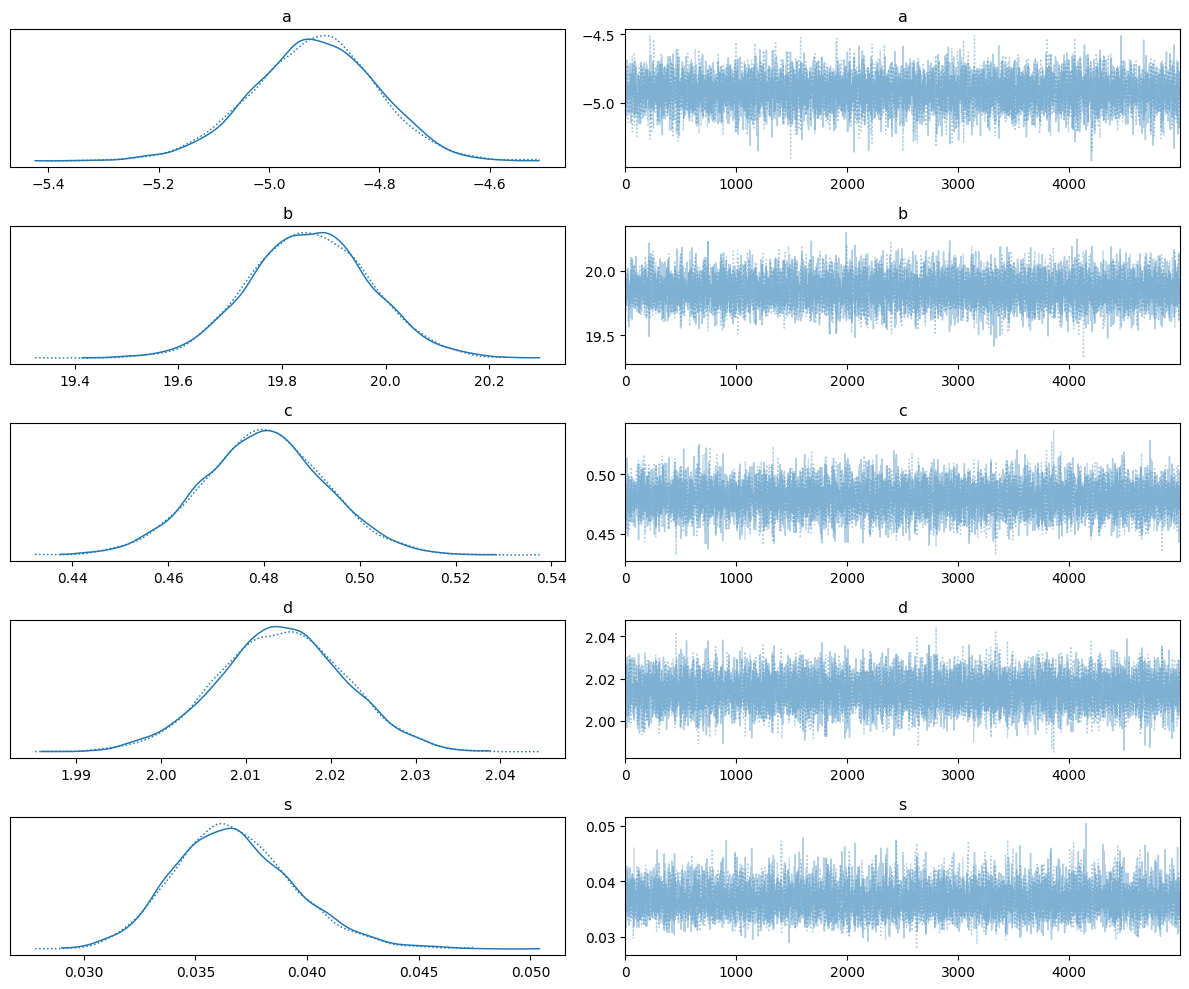

In [7]:
_ = az.plot_trace(result, var_names=['a', 'b', 'c', 'd', 's'])
plt.tight_layout()
plt.show()

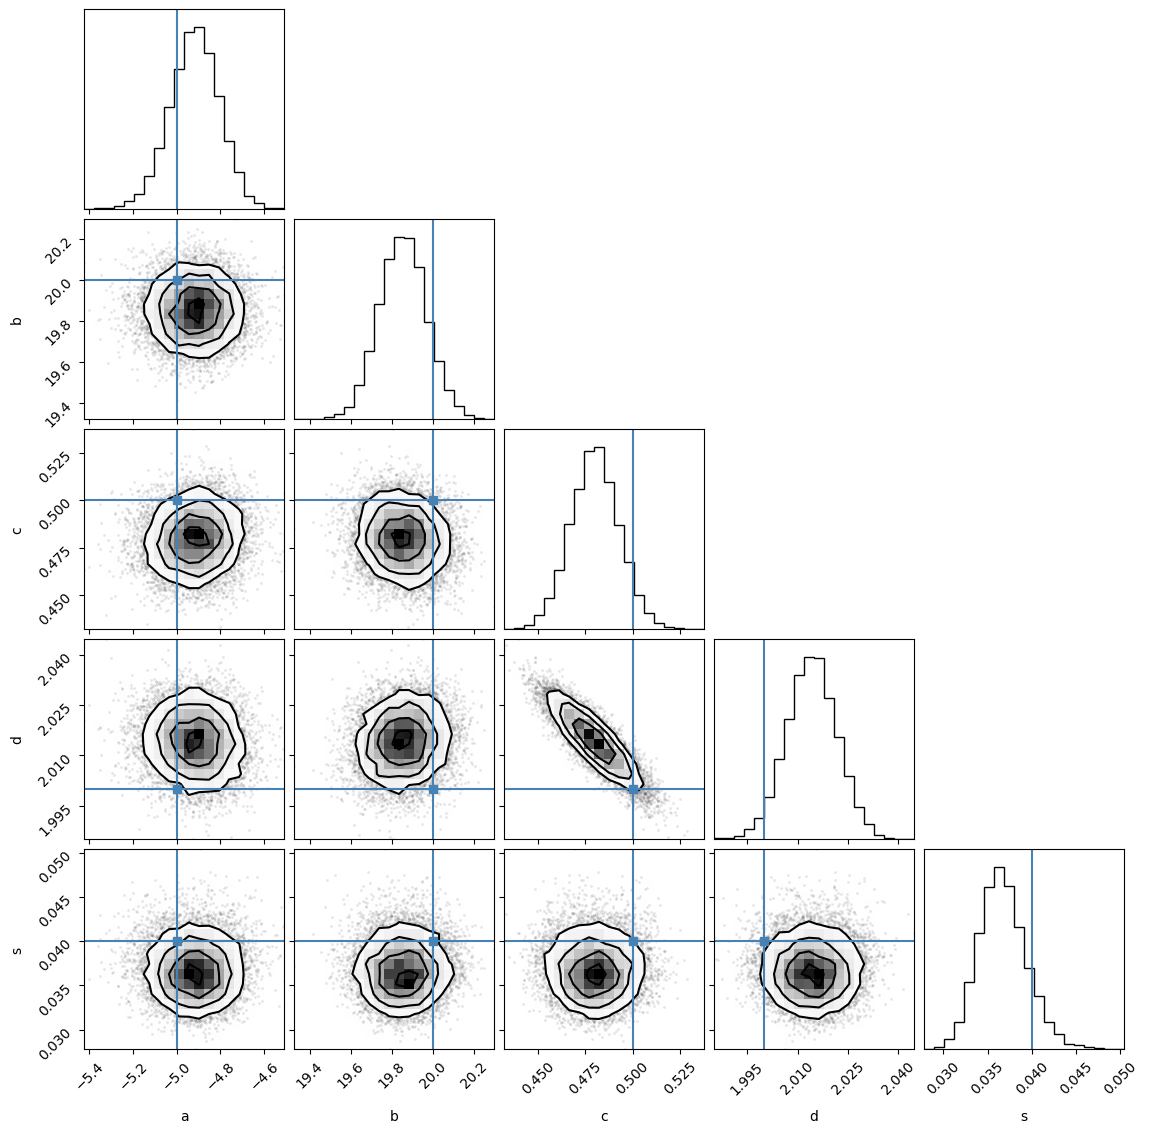

In [8]:
# Corner plot
truth = dict(zip(['a', 'b', 'c', 'd', 's'], np.array([-5, 20, 0.5, 2, 0.04]),))
_ = corner.corner(result, var_names=['a', 'b', 'c', 'd', 's'], truths=truth,);
plt.show()

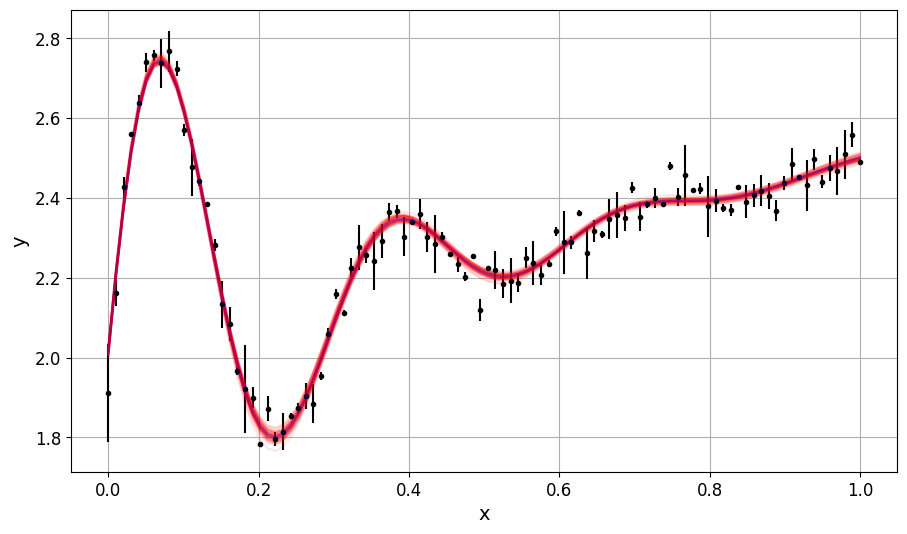

In [9]:
# Defining posteriors for each variable
y1 = np.array(result.posterior['y'][0,:,:])

# Plotting the results
fig, axs = plt.subplots(figsize=(16/1.5, 9/1.5))
axs.errorbar(x, y, yerr=yerr, fmt='.', color='k')
axs.plot(x, np.nanmedian(y1, axis=0), 'b-', alpha=0.3, lw=2., zorder=10)
for i in range(50):
    axs.plot(x, y1[np.random.choice(np.arange(5000), replace=False),:], 'r-', alpha=0.1)
axs.set_xlabel('x', fontsize=14)
axs.set_ylabel('y', fontsize=14)
plt.setp(axs.get_xticklabels(), fontsize=12)
plt.setp(axs.get_yticklabels(), fontsize=12)
plt.grid()
plt.show()